# Проект: Статистический анализ данных аренды самокатов GoFast

Предаставлены данные популярного сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

БЕЗ ПОДПИСКИ:
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

С ПОДПИСКОЙ ULTRA
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

ПЛАН РАБОТЫ:
- Шаг 1. Загрузка данных
- Шаг 2. Предобработка данных
- Шаг 3. Исследовательский анализ данных. Общая информация о пользователях и поездках:частота встречаемости городов; соотношение пользователей с подпиской и без подписки; возраст пользователей;  расстояние, которое пользователь преодолел за одну поездку; продолжительность поездок.
- Шаг 4. Объединение данных. Информация о расстоянии и времени поездок для пользователей обеих категорий.
- Шаг 5. Подсчёт выручки
- Шаг 6. Проверка гипотез. Важно понять, тратят ли пользователи с подпиской больше времени на поездки?  Если да, то пользователи с подпиской могут быть «выгоднее» для компании.
- Шаг 7. Распределения. Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

#### Шаг 1. Загрузка данных

In [ ]:
users_go = pd.read_csv('/datasets/users_go.csv')
print(users_go.head())

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra


In [ ]:
rides_go = pd.read_csv('/datasets/rides_go.csv')
print(rides_go.head())

   user_id     distance   duration        date
0        1  4409.919140  25.599769  2021-01-01
1        1  2617.592153  15.816871  2021-01-18
2        1   754.159807   6.232113  2021-04-20
3        1  2694.783254  18.511000  2021-08-11
4        1  4028.687306  26.265803  2021-08-28


In [ ]:
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
print(subscriptions_go.head())

  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199


In [ ]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [ ]:
users_go.isnull().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [ ]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [ ]:
rides_go.isnull().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [ ]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [ ]:
subscriptions_go.isnull().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

ВЫВОД:
- users_go : 1565 записи, пропуски отсутствуют.
- users_go : 18068 записи, пропуски отсутствуют.
- subscriptions_go : 2 записи, пропуски отсутствуют. Названия столбцов в норме. Для целого ряда столбцов некорректный тип данных. Данные признаны полными и достаточными для исследования.

#### Шаг 2. Предобработка данных

In [ ]:
rides_go['distance'] = rides_go['distance'].round(2)

In [ ]:
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')

In [ ]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [ ]:
rides_go['month'] = rides_go['date'].dt.month

Обработали данные rides_go:
- округлили distance в метрах до 2 знаков после запятой
- округлили duration до целых вверх и перевели в int
- привели столбец date к типу datetime64
- создали столбец month с номером месяца из date

#### Шаг 3. Исследовательский анализ данных

3.1.Частота встречаемых городов

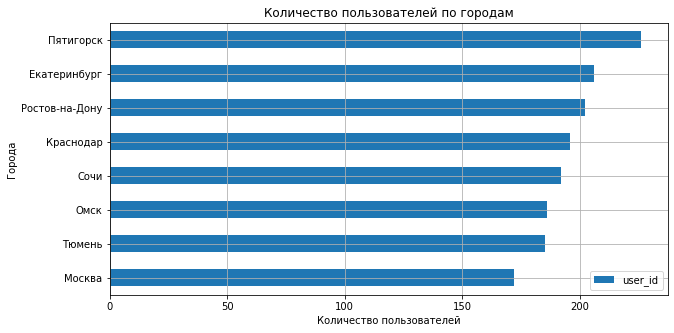

In [ ]:
(
    users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True)
    .plot(kind='barh', grid=True, figsize=(10, 5))
)
plt.title('Количество пользователей по городам')
plt.ylabel('Города')
plt.xlabel('Количество пользователей')
plt.show()

In [ ]:
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

,user_id
city,
Пятигорск,226
Екатеринбург,206
Ростов-на-Дону,202
Краснодар,196
Сочи,192
Омск,186
Тюмень,185
Москва,172


График количества пользователей по городам показывает, что первенство держит город Пятигорск за ним Екатеринбург, Ростов-на-Дону. Впервой половине располагаются в основном южные города, где сезон проката больше, исключение составляет г.Екатеринбург, находящийся на 2 позиции.

3.2.Соотношение пользователей с подпиской и без подписки

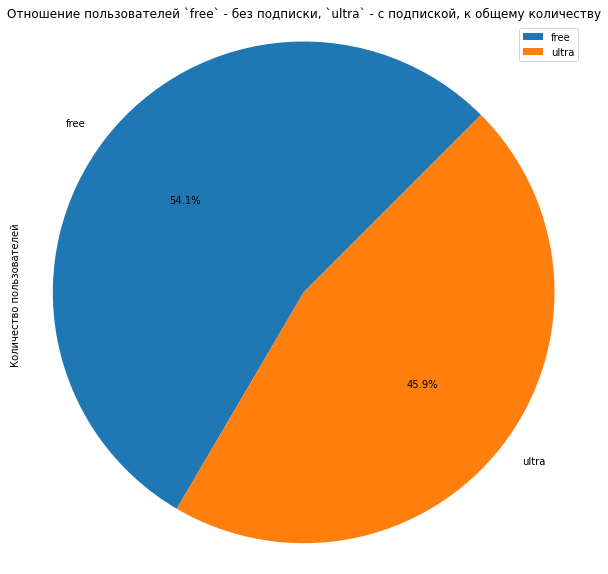

In [ ]:
(
    users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot.pie(y='user_id', figsize=(10,10),  label='Количество пользователей',
    autopct='%1.1f%%', startangle=45,
    title='Отношение пользователей `free` - без подписки, `ultra` - с подпиской, к общему количеству')

)
plt.axis('equal')
plt.show()

Количество пользователей без подписки free 54,1% превышает количество пользователей с подпиской ultra 45,9%.

3.3.Возраст пользователей

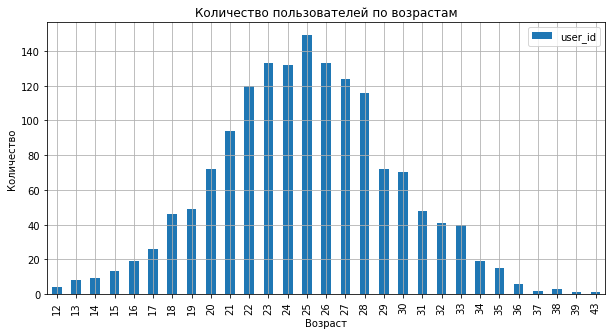

In [ ]:
(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True)
    .plot(kind='bar' , grid=True, figsize=(10, 5))
)
plt.title('Количество пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

In [ ]:
users_go['age'].mean().round(1)

24.9

In [ ]:
users_go['age'].describe()

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Гистограмма количества пользователей в зависимости от возраста указывает, что средний возраст потребителя услуги подчиняется нормальному распределению с медианой примерно в 25 лет, при этом средний возраст и медиана практически совпадают.

3.4.Расстояние, которое пользователь преодолел за одну поездку

In [ ]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

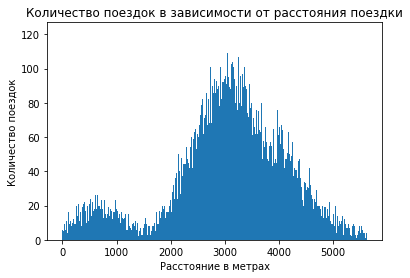

In [ ]:
plt.hist(rides_go['distance'], bins=500, range=(1,5620))
plt.title('Количество поездок в зависимости от расстояния поездки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

In [ ]:
rides_go['distance'].median()

3133.61

Гистограмма количества поездок в зависимости от расстояния указывает, медиана поездок находится на 3133 метров.

3.5.Пролжительность поездок

In [ ]:
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

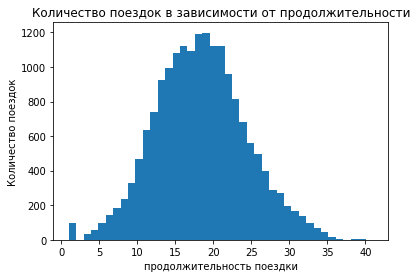

In [ ]:
plt.hist(rides_go['duration'], bins=41, range=(1,41))
plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Гистограмма количества поездок в зависимости от продолжительности указывает, среднее значение поездок находится на 18 мин. Замечено аномальное время поездок порядка 100 с временем менее 1 минуты.

#### Шаг 4. Объединение данных

In [ ]:
data = pd.merge(users_go, subscriptions_go, on='subscription_type')
data = pd.merge(rides_go, data, on='user_id')

In [ ]:
print('Количество явных дубликатов = ', data.duplicated().sum())
data.info()

Количество явных дубликатов =  320
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   distance           18388 non-null  float64       
 2   duration           18388 non-null  int64         
 3   date               18388 non-null  datetime64[ns]
 4   month              18388 non-null  int64         
 5   name               18388 non-null  object        
 6   age                18388 non-null  int64         
 7   city               18388 non-null  object        
 8   subscription_type  18388 non-null  object        
 9   minute_price       18388 non-null  int64         
 10  start_ride_price   18388 non-null  int64         
 11  subscription_fee   18388 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.8+ MB


In [ ]:
data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Созданный датафрейм объединяет таблицы rides_go, users_go, subscriptions_go в своем составе имеет 18068 строк во всех столбцах, что соответствует исходной таблице rides_go. 320 явных дубликатов.

In [ ]:
data_free = data[data['subscription_type'] == 'free']

In [ ]:
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6672,700,2515.69,15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6673,700,846.93,17,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6674,700,4004.43,21,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6675,700,1205.91,10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6676,700,3047.38,18,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [ ]:
data_ultra = data[data['subscription_type'] == 'ultra']

In [ ]:
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [ ]:
if len(data) == (len(data_free) + len(data_ultra)):
    print('Разделение прошло успешно')
else:
    print('Что-то пошло не так')

Разделение прошло успешно


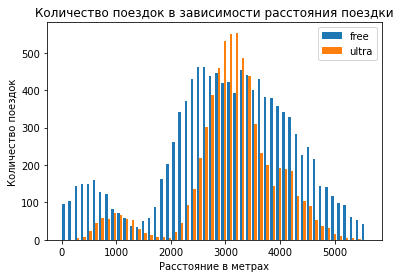

In [ ]:
plt.hist([data_free['distance'], data_ultra['distance']], bins=50, range=(1,5600), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости расстояния поездки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

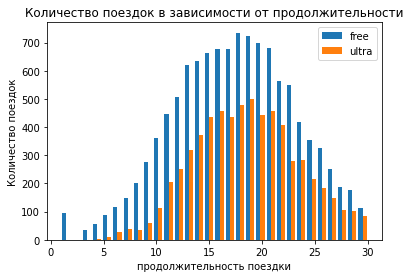

In [ ]:
plt.hist([data_free['duration'], data_ultra['duration']], bins=30, range=(1,30), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

In [ ]:
data_free['distance'].describe()

count    11716.000000
mean      3045.357338
std       1246.269591
min          0.860000
25%       2366.995000
50%       3114.665000
75%       3903.765000
max       7211.010000
Name: distance, dtype: float64

In [ ]:
data_ultra['distance'].describe()

count    6672.000000
mean     3115.435009
std       836.687033
min       244.210000
25%      2785.360000
50%      3148.735000
75%      3559.722500
max      5699.770000
Name: distance, dtype: float64

In [ ]:
data_free['duration'].describe()

count    11716.000000
mean        17.894503
std          6.329518
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [ ]:
data_ultra['duration'].describe()

count    6672.000000
mean       19.026679
std         5.578446
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

Вывод:

Визуализация по пользователям без подписки free и с подпиской ultra указывает, что подписка влияет на медианные значения (расстояния поезки без подписки 3114.65 метров с подпиской 3148.64 метров), при этом заметно что у пользователей с подпиской меньший разброс ( видно из графиков и по стандартному отклонению free - 1246,17 ultra - 836.89), также заметно смешение центра дополнительного пика с 500 метров (free) до 1000 (ultra).

Визуализация созданных датафреймов зависимости количества поездок за определенное время и описательная статистика по пользователям без подписки free и с подпиской ultra указывает, что подписка влияет на медианные значения (время поезки без подписки 18 мин с подпиской 19 мин), так же замечено снижение стандартного отклонения free - 6.33 ultra - 5.57.

Подписка влияет на расстояние поездок и на время в пути

#### Шаг 5. Подсчёт выручки

In [ ]:
users_months_revenue = data.pivot_table(
    index=('user_id', 'month'),
    values=(
        'distance',
        'duration',
        'minute_price',
        'start_ride_price',
        'subscription_fee'
    ),
    aggfunc=({'distance':{'count', 'sum'},
             'duration':'sum',
             'minute_price': 'mean',
             'start_ride_price':'mean',
             'subscription_fee':'mean',})
)

In [ ]:
users_months_revenue.columns = [
    'count', 'distance',
    'duration',
    'minute_price',
    'start_ride_price',
    'subscription_fee'
]

In [ ]:
users_months_revenue.head()

count  distance  duration  minute_price  start_ride_price  \
user_id month                                                              
1       1          2   7027.51        42             6                 0   
        4          1    754.16         7             6                 0   
        8          2   6723.47        46             6                 0   
        10         2   5809.91        32             6                 0   
        11         3   7003.50        56             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199

In [ ]:
users_months_revenue['revenue'] = (
users_months_revenue['start_ride_price']*users_months_revenue['count']+
users_months_revenue['minute_price']*users_months_revenue['duration']+
users_months_revenue['subscription_fee'])

print('Записи с ', data['date'].min(), 'по', data['date'].max())
print ('Выручка за 2021 год составила :',users_months_revenue['revenue'].sum(), 'руб.')

Записи с  2021-01-01 00:00:00 по 2021-12-30 00:00:00
Выручка за 2021 год составила : 3926759 руб.


#### Шаг 6. Проверка гипотез

In [ ]:
results = st.ttest_ind(
    data_ultra['duration'],
    data_free['duration'],
    equal_var=True,
    alternative='greater')
print(results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

3.1973284248890177e-34
Отвергаем нулевую гипотезу


Вывод:

Cредняя продолжительность поездки с подпиской больше продолжительности поездок без подписки при установленном уровне значимости в 5 %, хотя на гистограммах, это практически не прослеживается.

In [ ]:
results = st.ttest_ind(
    users_months_revenue.loc[users_months_revenue['subscription_fee'] > 0, 'revenue'],
    users_months_revenue.loc[users_months_revenue['subscription_fee'] == 0, 'revenue'],
    equal_var=True,
    alternative='greater')
print(results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

4.227438894541132e-29
Отвергаем нулевую гипотезу


Средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки, при установленном уровне значимости в 5 %.